__IMPORTING__

In [1]:
import pandas as pd
import numpy as np
import shap
from tqdm import tqdm

from lightgbm import LGBMClassifier, plot_metric, plot_tree, create_tree_digraph
from sklearn.model_selection import GridSearchCV

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import (mean_squared_error, accuracy_score)

from sklearn.model_selection import train_test_split
import shap
import random

#from plotting import (multiple_histograms_plot, plot_confusion_matrix, plot_roc)
#from evaluation import predictions_hist, confusion_matrix_report, grid_search_report
#from auto_lgbm import find_n_estimators, grid_search

In [2]:
total_lines = 8921484
skip_rows = np.arange(1, total_lines, 1)
skip_rows = random.sample(list(skip_rows), total_lines - 1000000)
df_orig = pd.read_csv("../input/microsoft-malware-prediction/train.csv", skiprows= skip_rows) 

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (28) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


__EDA__

For EDA we analysed feature by feature, researching their meanings and selecting the ones appeared to have a higher impact on a malware infection.

__FEATURE ENGINEERING__

In [3]:
df = df_orig.drop(['Census_FlightRing',
                  'Census_PrimaryDiskTypeName',
                  'Census_IsFlightingInternal',
                  'GeoNameIdentifier',
                  'Census_MDC2FormFactor',
                  'OsPlatformSubRelease',
                  'Census_ActivationChannel',
                  'Census_OSSkuName',
                  'Census_OSBranch',
                  'Census_OSArchitecture',
                  'Census_InternalBatteryNumberOfCharges',
                  'Census_PowerPlatformRoleName',
                  'OsBuildLab',
                  'MachineIdentifier',
                  'PuaMode', 
                  'Census_ProcessorClass', 
                  'DefaultBrowsersIdentifier', 
                  'Census_InternalBatteryType'], axis=1)

In [4]:
pd.set_option('display.max_columns',100)
df.head()

,ProductName,EngineVersion,AppVersion,AvSigVersion,IsBeta,RtpStateBitfield,IsSxsPassiveMode,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,CityIdentifier,OrganizationIdentifier,LocaleEnglishNameIdentifier,Platform,Processor,OsVer,OsBuild,OsSuite,SkuEdition,IsProtected,AutoSampleOptIn,SMode,IeVerIdentifier,SmartScreen,Firewall,UacLuaenable,Census_DeviceFamily,Census_OEMNameIdentifier,Census_OEMModelIdentifier,Census_ProcessorCoreCount,Census_ProcessorManufacturerIdentifier,Census_ProcessorModelIdentifier,Census_PrimaryDiskTotalCapacity,Census_SystemVolumeTotalCapacity,Census_HasOpticalDiskDrive,Census_TotalPhysicalRAM,Census_ChassisTypeName,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_OSVersion,Census_OSBuildNumber,Census_OSBuildRevision,Census_OSEdition,Census_OSInstallTypeName,Census_OSInstallLanguageIdentifier,Census_OSUILocaleIdentifier,Census_OSWUAutoUpdateOptionsName,Census_IsPortableOperatingSystem,Census_GenuineStateName,Census_IsFlightsDisabled,Census_ThresholdOptIn,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections
0,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1735.0,0,7.0,0,53447.0,1.0,1.0,1,29,128035.0,18.0,171,windows10,x64,10.0.0.0,17134,256,Pro,1.0,0,0.0,137.0,NaN,1.0,1.0,Windows.Desktop,2668.0,9124.0,4.0,5.0,2341.0,476940.0,299451.0,0,4096.0,Desktop,18.9,1440.0,900.0,10.0.17134.165,17134,165,Professional,UUPUpgrade,26.0,119,UNKNOWN,0,IS_GENUINE,0.0,NaN,628.0,36144.0,0,NaN,0.0,0,0,0.0,0.0,10.0,0
1,win8defender,1.1.15200.1,4.18.1807.18075,1.275.988.0,0,7.0,0,53447.0,1.0,1.0,1,164,155006.0,27.0,172,windows10,x64,10.0.0.0,17134,256,Pro,1.0,0,0.0,137.0,RequireAdmin,1.0,1.0,Windows.Desktop,2206.0,240688.0,4.0,5.0,2836.0,305245.0,303892.0,0,4096.0,Notebook,15.6,1920.0,1080.0,10.0.17134.254,17134,254,Professional,Update,27.0,120,FullAuto,0,IS_GENUINE,0.0,0.0,500.0,15510.0,0,0.0,0.0,0,0,0.0,0.0,15.0,0
2,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1826.0,0,7.0,0,47238.0,2.0,1.0,1,164,120983.0,27.0,172,windows10,x64,10.0.0.0,17134,768,Home,1.0,0,0.0,137.0,NaN,1.0,1.0,Windows.Desktop,2668.0,172079.0,2.0,5.0,2097.0,122104.0,120827.0,0,4096.0,Notebook,13.9,1366.0,768.0,10.0.17134.228,17134,228,Core,Upgrade,27.0,120,FullAuto,0,IS_GENUINE,0.0,NaN,628.0,15816.0,1,NaN,0.0,0,0,0.0,0.0,15.0,1
3,win8defender,1.1.15200.1,4.18.1807.18075,1.275.895.0,0,7.0,0,53447.0,1.0,1.0,1,171,124736.0,NaN,182,windows10,x64,10.0.0.0,17134,256,Pro,1.0,0,0.0,137.0,RequireAdmin,1.0,1.0,Windows.Desktop,4589.0,313586.0,2.0,5.0,3470.0,953869.0,953034.0,0,8192.0,Desktop,21.5,1920.0,1080.0,10.0.17134.228,17134,228,Professional,UUPUpgrade,29.0,125,FullAuto,0,IS_GENUINE,0.0,NaN,142.0,11081.0,0,NaN,0.0,0,0,0.0,0.0,3.0,0
4,win8defender,1.1.15100.1,4.8.10240.17914,1.273.356.0,0,7.0,0,53447.0,1.0,1.0,1,43,12607.0,27.0,42,windows10,x64,10.0.0.0,10240,256,Enterprise LTSB,1.0,0,0.0,65.0,RequireAdmin,1.0,1.0,Windows.Desktop,666.0,264571.0,4.0,5.0,2699.0,477102.0,363314.0,0,8192.0,Laptop,13.3,2560.0,1600.0,10.0.10240.17914,10240,17914,EnterpriseS,IBSClean,37.0,158,UNKNOWN,0,IS_GENUINE,0.0,0.0,NaN,NaN,0,0.0,0.0,0,0,0.0,1.0,7.0,1


In [5]:
df.dropna()

,ProductName,EngineVersion,AppVersion,AvSigVersion,IsBeta,RtpStateBitfield,IsSxsPassiveMode,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,CityIdentifier,OrganizationIdentifier,LocaleEnglishNameIdentifier,Platform,Processor,OsVer,OsBuild,OsSuite,SkuEdition,IsProtected,AutoSampleOptIn,SMode,IeVerIdentifier,SmartScreen,Firewall,UacLuaenable,Census_DeviceFamily,Census_OEMNameIdentifier,Census_OEMModelIdentifier,Census_ProcessorCoreCount,Census_ProcessorManufacturerIdentifier,Census_ProcessorModelIdentifier,Census_PrimaryDiskTotalCapacity,Census_SystemVolumeTotalCapacity,Census_HasOpticalDiskDrive,Census_TotalPhysicalRAM,Census_ChassisTypeName,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_OSVersion,Census_OSBuildNumber,Census_OSBuildRevision,Census_OSEdition,Census_OSInstallTypeName,Census_OSInstallLanguageIdentifier,Census_OSUILocaleIdentifier,Census_OSWUAutoUpdateOptionsName,Census_IsPortableOperatingSystem,Census_GenuineStateName,Census_IsFlightsDisabled,Census_ThresholdOptIn,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections
1,win8defender,1.1.15200.1,4.18.1807.18075,1.275.988.0,0,7.0,0,53447.0,1.0,1.0,1,164,155006.0,27.0,172,windows10,x64,10.0.0.0,17134,256,Pro,1.0,0,0.0,137.0,RequireAdmin,1.0,1.0,Windows.Desktop,2206.0,240688.0,4.0,5.0,2836.0,305245.0,303892.0,0,4096.0,Notebook,15.6,1920.0,1080.0,10.0.17134.254,17134,254,Professional,Update,27.0,120,FullAuto,0,IS_GENUINE,0.0,0.0,500.0,15510.0,0,0.0,0.0,0,0,0.0,0.0,15.0,0
7,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1565.0,0,7.0,0,53447.0,1.0,1.0,1,214,71958.0,27.0,75,windows10,x64,10.0.0.0,16299,768,Home,1.0,0,0.0,117.0,RequireAdmin,1.0,1.0,Windows.Desktop,525.0,331212.0,4.0,5.0,3026.0,476940.0,226164.0,0,4096.0,Notebook,15.5,1366.0,768.0,10.0.16299.371,16299,371,CoreSingleLanguage,Upgrade,8.0,156,Notify,0,IS_GENUINE,0.0,0.0,142.0,69919.0,0,0.0,0.0,0,0,0.0,1.0,1.0,1
8,win8defender,1.1.15100.1,4.8.10240.16384,1.273.1073.0,0,7.0,0,7945.0,2.0,1.0,1,29,114749.0,18.0,171,windows10,x64,10.0.0.0,10240,768,Home,1.0,0,0.0,41.0,Off,1.0,1.0,Windows.Desktop,1475.0,273318.0,2.0,5.0,2042.0,476940.0,176538.0,1,2048.0,Notebook,14.0,1366.0,768.0,10.0.10240.16384,10240,16384,Core,IBSClean,26.0,119,UNKNOWN,0,INVALID_LICENSE,0.0,0.0,142.0,4753.0,0,0.0,0.0,0,0,0.0,0.0,10.0,0
15,win8defender,1.1.15100.1,4.18.1806.18062,1.273.505.0,0,7.0,0,53447.0,1.0,1.0,1,195,10222.0,18.0,74,windows10,x64,10.0.0.0,15063,768,Home,1.0,0,0.0,108.0,ExistsNotSet,1.0,1.0,Windows.Desktop,2668.0,97906.0,4.0,5.0,2525.0,61057.0,59635.0,0,8192.0,Notebook,15.5,1366.0,768.0,10.0.15063.1206,15063,1206,Core,Update,8.0,31,Notify,0,IS_GENUINE,0.0,0.0,628.0,12952.0,0,0.0,0.0,0,0,0.0,0.0,1.0,1
16,win8defender,1.1.15200.1,4.18.1807.18075,1.275.54.0,0,7.0,0,62773.0,1.0,1.0,1,41,130775.0,18.0,217,windows10,x64,10.0.0.0,16299,256,Pro,0.0,0,0.0,135.0,RequireAdmin,1.0,1.0,Windows.Desktop,2102.0,229904.0,2.0,5.0,2035.0,476940.0,410981.0,0,4096.0,Notebook,15.5,1366.0,768.0,10.0.16299.125,16299,125,ProfessionalEducation,Upgrade,10.0,35,Notify,0,IS_GENUINE,0.0,0.0,554.0,33102.0,0,0.0,0.0,0,0,0.0,1.0,10.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999982,win8defender,1.1.15200.1,4.9.10586.1106,1.275.1141.0,0,7.0,0,7945.0,2.0,1.0,1,173,67513.0,27.0,16,windows10,x64,10.0.0.0,10586,256,Pro,1.0,0,0.0,74.0,ExistsNotSet,1.0,1.0,Windows.Desktop,1443.0,256779.0,4.0,5.0,2256.0,476940.0,276838.0,0,3072.0,Portable,15.5,1366.0,768.0,10.0.10586.1176,10586,1176,Pr

In [6]:
df.loc[:,'AppVersion'] = df['AppVersion'].astype('category')
df.loc[:,'AvSigVersion'] = df['AvSigVersion'].astype('category')
df.loc[:,'EngineVersion'] = df['EngineVersion'].astype('category')
df.loc[:,'UacLuaenable'] = df['UacLuaenable'].astype('category')
df.loc[:,'ProductName'] = df['ProductName'].astype('category')
df.loc[:,'Processor'] = df['Processor'].astype('category')
df.loc[:,'Platform'] = df['Platform'].astype('category')
df.loc[:,'SkuEdition'] = df['SkuEdition'].astype('category')
df.loc[:,'LocaleEnglishNameIdentifier'] = df['LocaleEnglishNameIdentifier'].astype('category')
df.loc[:,'OrganizationIdentifier'] = df['OrganizationIdentifier'].astype('category')
df.loc[:,'CityIdentifier'] = df['CityIdentifier'].astype('category')
df.loc[:,'SmartScreen'] = df['SmartScreen'].astype('category')
df.loc[:,'Census_DeviceFamily'] = df['Census_DeviceFamily'].astype('category')
df.loc[:,'Census_OSInstallTypeName'] = df['Census_OSInstallTypeName'].astype('category')
df.loc[:,'Census_OSEdition'] = df['Census_OSEdition'].astype('category')
df.loc[:,'OsVer'] = df['OsVer'].astype('category')
df.loc[:,'Census_OSVersion'] = df['Census_OSVersion'].astype('category')
df.loc[:,'Census_OEMNameIdentifier'] = df['Census_OEMNameIdentifier'].astype('category')
df.loc[:,'Census_OEMModelIdentifier'] = df['Census_OEMModelIdentifier'].astype('category')
df.loc[:,'Census_ProcessorManufacturerIdentifier'] = df['Census_ProcessorManufacturerIdentifier'].astype('category')
df.loc[:,'Census_ProcessorModelIdentifier'] = df['Census_ProcessorModelIdentifier'].astype('category')
df.loc[:,'Census_ChassisTypeName'] = df['Census_ChassisTypeName'].astype('category')
df.loc[:,'Census_OSBuildNumber'] = df['Census_OSBuildNumber'].astype('category')
df.loc[:,'Census_OSInstallLanguageIdentifier'] = df['Census_OSInstallLanguageIdentifier'].astype('category')
df.loc[:,'Census_OSUILocaleIdentifier'] = df['Census_OSUILocaleIdentifier'].astype('category')
df.loc[:,'Census_FirmwareManufacturerIdentifier'] = df['Census_FirmwareManufacturerIdentifier'].astype('category')
df.loc[:,'Census_FirmwareVersionIdentifier'] = df['Census_FirmwareVersionIdentifier'].astype('category')
df.loc[:,'CountryIdentifier'] = df['CountryIdentifier'].astype('category')


In [7]:
le = LabelEncoder()
grade_intlabels = le.fit_transform(df['Census_OSWUAutoUpdateOptionsName'])
df.loc[:,'Census_OSWUAutoUpdateOptionsName'] = grade_intlabels

In [8]:
le = LabelEncoder()
grade_intlabels = le.fit_transform(df['Census_GenuineStateName'])
df.loc[:,'Census_GenuineStateName'] = grade_intlabels

In [9]:
pd.set_option('display.max_columns',100)
df.head()

,ProductName,EngineVersion,AppVersion,AvSigVersion,IsBeta,RtpStateBitfield,IsSxsPassiveMode,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,CityIdentifier,OrganizationIdentifier,LocaleEnglishNameIdentifier,Platform,Processor,OsVer,OsBuild,OsSuite,SkuEdition,IsProtected,AutoSampleOptIn,SMode,IeVerIdentifier,SmartScreen,Firewall,UacLuaenable,Census_DeviceFamily,Census_OEMNameIdentifier,Census_OEMModelIdentifier,Census_ProcessorCoreCount,Census_ProcessorManufacturerIdentifier,Census_ProcessorModelIdentifier,Census_PrimaryDiskTotalCapacity,Census_SystemVolumeTotalCapacity,Census_HasOpticalDiskDrive,Census_TotalPhysicalRAM,Census_ChassisTypeName,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_OSVersion,Census_OSBuildNumber,Census_OSBuildRevision,Census_OSEdition,Census_OSInstallTypeName,Census_OSInstallLanguageIdentifier,Census_OSUILocaleIdentifier,Census_OSWUAutoUpdateOptionsName,Census_IsPortableOperatingSystem,Census_GenuineStateName,Census_IsFlightsDisabled,Census_ThresholdOptIn,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections
0,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1735.0,0,7.0,0,53447.0,1.0,1.0,1,29,128035.0,18.0,171,windows10,x64,10.0.0.0,17134,256,Pro,1.0,0,0.0,137.0,NaN,1.0,1.0,Windows.Desktop,2668.0,9124.0,4.0,5.0,2341.0,476940.0,299451.0,0,4096.0,Desktop,18.9,1440.0,900.0,10.0.17134.165,17134,165,Professional,UUPUpgrade,26.0,119,5,0,1,0.0,NaN,628.0,36144.0,0,NaN,0.0,0,0,0.0,0.0,10.0,0
1,win8defender,1.1.15200.1,4.18.1807.18075,1.275.988.0,0,7.0,0,53447.0,1.0,1.0,1,164,155006.0,27.0,172,windows10,x64,10.0.0.0,17134,256,Pro,1.0,0,0.0,137.0,RequireAdmin,1.0,1.0,Windows.Desktop,2206.0,240688.0,4.0,5.0,2836.0,305245.0,303892.0,0,4096.0,Notebook,15.6,1920.0,1080.0,10.0.17134.254,17134,254,Professional,Update,27.0,120,2,0,1,0.0,0.0,500.0,15510.0,0,0.0,0.0,0,0,0.0,0.0,15.0,0
2,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1826.0,0,7.0,0,47238.0,2.0,1.0,1,164,120983.0,27.0,172,windows10,x64,10.0.0.0,17134,768,Home,1.0,0,0.0,137.0,NaN,1.0,1.0,Windows.Desktop,2668.0,172079.0,2.0,5.0,2097.0,122104.0,120827.0,0,4096.0,Notebook,13.9,1366.0,768.0,10.0.17134.228,17134,228,Core,Upgrade,27.0,120,2,0,1,0.0,NaN,628.0,15816.0,1,NaN,0.0,0,0,0.0,0.0,15.0,1
3,win8defender,1.1.15200.1,4.18.1807.18075,1.275.895.0,0,7.0,0,53447.0,1.0,1.0,1,171,124736.0,NaN,182,windows10,x64,10.0.0.0,17134,256,Pro,1.0,0,0.0,137.0,RequireAdmin,1.0,1.0,Windows.Desktop,4589.0,313586.0,2.0,5.0,3470.0,953869.0,953034.0,0,8192.0,Desktop,21.5,1920.0,1080.0,10.0.17134.228,17134,228,Professional,UUPUpgrade,29.0,125,2,0,1,0.0,NaN,142.0,11081.0,0,NaN,0.0,0,0,0.0,0.0,3.0,0
4,win8defender,1.1.15100.1,4.8.10240.17914,1.273.356.0,0,7.0,0,53447.0,1.0,1.0,1,43,12607.0,27.0,42,windows10,x64,10.0.0.0,10240,256,Enterprise LTSB,1.0,0,0.0,65.0,RequireAdmin,1.0,1.0,Windows.Desktop,666.0,264571.0,4.0,5.0,2699.0,477102.0,363314.0,0,8192.0,Laptop,13.3,2560.0,1600.0,10.0.10240.17914,10240,17914,EnterpriseS,IBSClean,37.0,158,5,0,1,0.0,0.0,NaN,NaN,0,0.0,0.0,0,0,0.0,1.0,7.0,1


__TRAINING THE MODEL__

In [10]:
X = df.drop(columns=['HasDetections'])
y = df['HasDetections']

In [11]:
X_cat = df.drop(columns=['HasDetections'])

X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(X_cat, y, test_size=0.2, 
                                                                    random_state=0)

In [12]:
validation_size = 0.25

X_dev, X_val, y_dev, y_val = train_test_split(X_train_cat, y_train_cat, 
                                              test_size=validation_size, 
                                              random_state=0)

In [13]:
lgbm = LGBMClassifier(n_estimators=5000,
                         class_weight='balanced', random_state=0)

In [14]:
_ = lgbm.fit(X_dev, y_dev, eval_set=(X_val, y_val), early_stopping_rounds = 50)

[1]	valid_0's binary_logloss: 0.682733
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's binary_logloss: 0.674275
[3]	valid_0's binary_logloss: 0.667228
[4]	valid_0's binary_logloss: 0.661399
[5]	valid_0's binary_logloss: 0.656423
[6]	valid_0's binary_logloss: 0.652124
[7]	valid_0's binary_logloss: 0.648461
[8]	valid_0's binary_logloss: 0.645394
[9]	valid_0's binary_logloss: 0.64282
[10]	valid_0's binary_logloss: 0.640509
[11]	valid_0's binary_logloss: 0.638331
[12]	valid_0's binary_logloss: 0.636595
[13]	valid_0's binary_logloss: 0.634852
[14]	valid_0's binary_logloss: 0.633484
[15]	valid_0's binary_logloss: 0.632295
[16]	valid_0's binary_logloss: 0.631333
[17]	valid_0's binary_logloss: 0.630075
[18]	valid_0's binary_logloss: 0.62922
[19]	valid_0's binary_logloss: 0.628503
[20]	valid_0's binary_logloss: 0.627805
[21]	valid_0's binary_logloss: 0.627175
[22]	valid_0's binary_logloss: 0.626617
[23]	valid_0's binary_logloss: 0.626076
[24]	valid_0's binary_logloss

In [15]:
y_pred_proba = lgbm.predict_proba(X_test_cat)[:, 1]

In [16]:
_ = plot_roc(y_test_cat, y_pred_proba)

NameError: name 'plot_roc' is not defined

In [17]:
max_n_estimators = 5000
early_stopping_rounds = 50
learning_rates = [0.01, 0.03, 0.1]

In [18]:
lgbm_lr = LGBMClassifier(n_estimators=max_n_estimators, 
                         class_weight='balanced', random_state=0)

In [19]:
results = pd.DataFrame(columns=['learning_rate', 'best_n_estimators', 'best_log_loss'])

for learning_rate in tqdm(learning_rates):
    lgbm_lr.learning_rate = learning_rate
    
    lgbm_lr.fit(X_dev, y_dev, eval_set=(X_val, y_val), 
                early_stopping_rounds=early_stopping_rounds, verbose=False)
    
    results = results.append({'learning_rate': learning_rate, 
                              'best_n_estimators': lgbm_lr.best_iteration_,
                              'best_log_loss': lgbm_lr.best_score_['valid_0']['binary_logloss']},
                             ignore_index=True)

100%|██████████| 3/3 [04:32<00:00, 90.69s/it] 


In [20]:
results['learning_rate'] = results['learning_rate']
results['best_n_estimators'] = results['best_n_estimators'].astype(int)

results

,learning_rate,best_n_estimators,best_log_loss
0,0.01,883,0.619040
1,0.03,283,0.619184
2,0.10,75,0.619596


In [21]:
param_grids = [
    {'learning_rate': [0.01], 'n_estimators': [760]},
    {'learning_rate': [0.03], 'n_estimators': [276]},
    {'learning_rate': [0.1], 'n_estimators': [78]}
]

In [22]:
scoring = 'neg_log_loss'

In [23]:
grid_search_cv = GridSearchCV(lgbm_lr, param_grid = param_grids, scoring = scoring,
                             cv=5, verbose=2)

In [24]:
grid_search_cv.fit(X_train_cat, y_train_cat, verbose=False)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] learning_rate=0.01, n_estimators=760 ............................
[CV] ............. learning_rate=0.01, n_estimators=760, total= 2.7min
[CV] learning_rate=0.01, n_estimators=760 ............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.7min remaining:    0.0s


[CV] ............. learning_rate=0.01, n_estimators=760, total= 2.8min
[CV] learning_rate=0.01, n_estimators=760 ............................
[CV] ............. learning_rate=0.01, n_estimators=760, total= 2.8min
[CV] learning_rate=0.01, n_estimators=760 ............................
[CV] ............. learning_rate=0.01, n_estimators=760, total= 2.7min
[CV] learning_rate=0.01, n_estimators=760 ............................
[CV] ............. learning_rate=0.01, n_estimators=760, total= 2.8min
[CV] learning_rate=0.03, n_estimators=276 ............................
[CV] ............. learning_rate=0.03, n_estimators=276, total= 1.0min
[CV] learning_rate=0.03, n_estimators=276 ............................
[CV] ............. learning_rate=0.03, n_estimators=276, total= 1.0min
[CV] learning_rate=0.03, n_estimators=276 ............................
[CV] ............. learning_rate=0.03, n_estimators=276, total= 1.1min
[CV] learning_rate=0.03, n_estimators=276 ............................
[CV] .

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed: 20.7min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LGBMClassifier(boosting_type='gbdt',
                                      class_weight='balanced',
                                      colsample_bytree=1.0,
                                      importance_type='split',
                                      learning_rate=0.1, max_depth=-1,
                                      min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0, n_estimators=5000,
                                      n_jobs=-1, num_leaves=31, objective=None,
                                      random_state=0, reg_alpha=0.0,
                                      reg_lambda=0.0, silent=True,
                                      subsample=1.0, subsample_for_bin=200000,
                                      subsample_freq=0),
             iid='warn', n_jobs=None,
             param_grid=[{'learning_rate':

__ANALYSING THE MODEL__

In [25]:
y_pred_proba_cv = grid_search_cv.predict_proba(X_test_cat)[:, 1]

In [26]:
confusion_matrix_report(y_test_cat, y_pred_proba_cv, thres=0.625)

NameError: name 'confusion_matrix_report' is not defined

In [27]:
_ = plot_roc(y_test_cat, y_pred_proba_cv)

NameError: name 'plot_roc' is not defined

In [28]:
X_train_sample = X_train_cat.sample(1_000, random_state=0)

In [29]:
explainer = shap.TreeExplainer(model=lgbm).shap_values(X_train_sample)

/opt/conda/lib/python3.6/site-packages/shap/explainers/tree.py:195: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


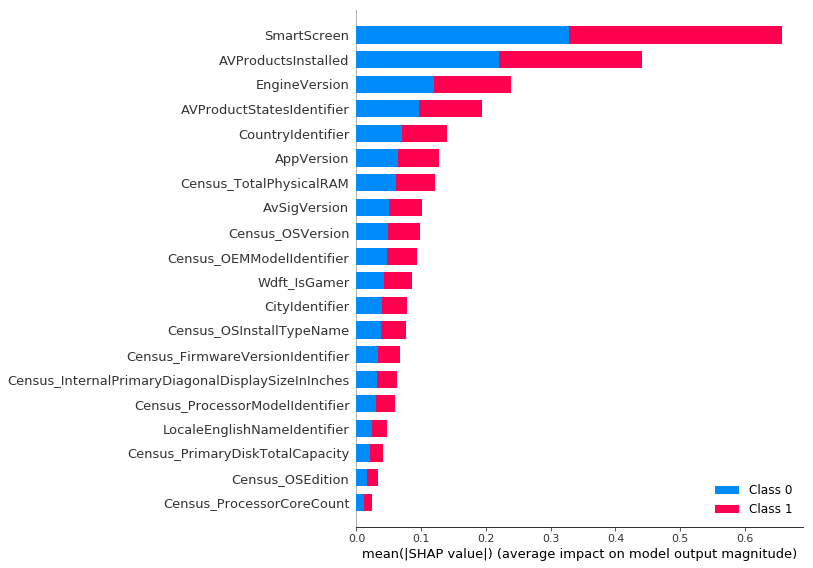

In [30]:
shap.summary_plot(explainer, X_train_sample, plot_type='bar')

__IMPORTING TEST DATASET__

In [31]:
df_test = pd.read_csv("../input/microsoft-malware-prediction/test.csv")

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (28) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


__FEATURE ENGINEERING TO TEST DATASET__

In [32]:
df_predict = df_test.drop(['Census_FlightRing',
                   'Census_PrimaryDiskTypeName',
                   'Census_IsFlightingInternal',
                   'GeoNameIdentifier',
                   'Census_MDC2FormFactor',
                   'OsPlatformSubRelease',
                   'Census_ActivationChannel',
                   'Census_OSSkuName',
                  'Census_OSBranch',
                   'Census_OSArchitecture',
                   'Census_InternalBatteryNumberOfCharges',
                   'Census_PowerPlatformRoleName',
                   'OsBuildLab',
                   'MachineIdentifier',
                   'PuaMode', 
                   'Census_ProcessorClass', 
                   'DefaultBrowsersIdentifier', 
                   'Census_InternalBatteryType'], axis=1)

In [33]:
df_predict.loc[:,'AppVersion'] = df['AppVersion'].astype('category')
df_predict.loc[:,'AvSigVersion'] = df['AvSigVersion'].astype('category')
df_predict.loc[:,'EngineVersion'] = df['EngineVersion'].astype('category')
df_predict.loc[:,'UacLuaenable'] = df['UacLuaenable'].astype('category')
df_predict.loc[:,'ProductName'] = df['ProductName'].astype('category')
df_predict.loc[:,'Processor'] = df['Processor'].astype('category')
df_predict.loc[:,'Platform'] = df['Platform'].astype('category')
df_predict.loc[:,'SkuEdition'] = df['SkuEdition'].astype('category')
df_predict.loc[:,'LocaleEnglishNameIdentifier'] = df['LocaleEnglishNameIdentifier'].astype('category')
df_predict.loc[:,'OrganizationIdentifier'] = df['OrganizationIdentifier'].astype('category')
df_predict.loc[:,'CityIdentifier'] = df['CityIdentifier'].astype('category')
df_predict.loc[:,'SmartScreen'] = df['SmartScreen'].astype('category')
df_predict.loc[:,'Census_DeviceFamily'] = df['Census_DeviceFamily'].astype('category')
df_predict.loc[:,'Census_OSInstallTypeName'] = df['Census_OSInstallTypeName'].astype('category')
df_predict.loc[:,'Census_OSEdition'] = df['Census_OSEdition'].astype('category')
df_predict.loc[:,'OsVer'] = df['OsVer'].astype('category')
df_predict.loc[:,'Census_OSVersion'] = df['Census_OSVersion'].astype('category')
df_predict.loc[:,'Census_OEMNameIdentifier'] = df['Census_OEMNameIdentifier'].astype('category')
df_predict.loc[:,'Census_OEMModelIdentifier'] = df['Census_OEMModelIdentifier'].astype('category')
df_predict.loc[:,'Census_ProcessorManufacturerIdentifier'] = df['Census_ProcessorManufacturerIdentifier'].astype('category')
df_predict.loc[:,'Census_ProcessorModelIdentifier'] = df['Census_ProcessorModelIdentifier'].astype('category')
df_predict.loc[:,'Census_ChassisTypeName'] = df['Census_ChassisTypeName'].astype('category')
df_predict.loc[:,'Census_OSBuildNumber'] = df['Census_OSBuildNumber'].astype('category')
df_predict.loc[:,'Census_OSInstallLanguageIdentifier'] = df['Census_OSInstallLanguageIdentifier'].astype('category')
df_predict.loc[:,'Census_OSUILocaleIdentifier'] = df['Census_OSUILocaleIdentifier'].astype('category')
df_predict.loc[:,'Census_FirmwareManufacturerIdentifier'] = df['Census_FirmwareManufacturerIdentifier'].astype('category')
df_predict.loc[:,'Census_FirmwareVersionIdentifier'] = df['Census_FirmwareVersionIdentifier'].astype('category')
df_predict.loc[:,'CountryIdentifier'] = df['CountryIdentifier'].astype('category')

In [34]:
le = LabelEncoder()
grade_intlabels = le.fit_transform(df['Census_OSWUAutoUpdateOptionsName'])
df_predict.loc[:,'Census_OSWUAutoUpdateOptionsName'] = grade_intlabels

ValueError: Must have equal len keys and value when setting with an iterable

In [35]:
le = LabelEncoder()
grade_intlabels = le.fit_transform(df['Census_GenuineStateName'])
df.loc[:,'Census_GenuineStateName'] = grade_intlabels

__PREDICTING__

In [36]:
y_pred = grid_search_cv.predict(X_test_cat)

print(accuracy_score(y_test_cat, y_pred)*100)

64.756


__MAKING A DATASET WITH PREDICIONS__

In [37]:
df_testid = pd.read_csv('../input/microsoft-malware-prediction/test.csv',usecols=[0])

In [38]:
df_pred = pd.DataFrame(y_pred)

In [39]:
df_submission = pd.concat([df_testid, df_pred], axis=1, join='inner', ignore_index=False, keys=None,
          levels=None, names=None, verify_integrity=False, copy=True)

In [40]:
df_submission[0]

df_tudo.set_axis(['id', 'inf'], axis=1, inplace= True)

NameError: name 'df_tudo' is not defined

In [41]:
len(df_submission[df_submission['inf'] == 1]['id'])

KeyError: 'inf'

In [42]:
df_submission[df_submission['inf'] == 1]['id']

KeyError: 'inf'

In [43]:
df_submission.to_csv('submission.csv', index=False)